# Flow Network Solver

### General imports

In [1]:
# %pylab
# %run FastFlowNets.py 64 1 0
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys, os
args = sys.argv
sys.executable

import numpy as np
import copy
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import array as array
from numpy import arange as arange
from numpy import meshgrid as meshgrid
from numpy import dot as dot
from numpy.linalg import inv as inv

import cProfile
import re
import time

import numpy.linalg as la
import numpy.random as rand
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from datetime import datetime

# My functions
import NETfuncs, Constraints, Matrixfuncs, Solve, Statistics, Classes

In [2]:
## for plots and data save

# figure size
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams.update({'font.size': 14})

# comp_path = "C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"
comp_path = "C:\\Users\\roiee\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"

In [3]:
# pip install networkx
# pip install nbconvert

### Roie Larger Network

In [4]:
NGrid = 50  # lattice dimansion is Ngrid X Ngrid
# input_output_pairs = np.array([[(NGrid+2)*5-1, (NGrid*(NGrid-2)+2)*5-1], 
#                               [(NGrid*(NGrid-1)-1)*5-1, (2*NGrid-1)*5-1]])

# NGrid = 3  # lattice dimansion is Ngrid X Ngrid
# task_type = 'Allostery_one_pair'
task_type = 'Allostery'  # 2 pairs of input and outpus
# task_type = 'XOR'  # 2 inputs and 2 outputs. difference between output nodes encodes the XOR result of the 2 inputs
# row = int(np.floor(np.sqrt(NGrid))-1)  # row (and column) of input and output nodes in the NGrid X NGrid cell array
row = 3
if task_type == 'Allostery' or task_type == 'XOR':
    input_output_pairs = np.array([[(row*NGrid+(row+1))*5-1, (NGrid*(NGrid-(row+1))+(row+1))*5-1], 
                                  [(NGrid*(NGrid-row)-row)*5-1, ((row+1)*NGrid-row)*5-1]])
    if task_type == 'XOR':
        fixed_node_pairs = np.array([[(NGrid*int(np.floor(NGrid/2))+2)*5-1],
                                     [(NGrid*int(np.floor(NGrid/2))+(NGrid-row))*5-1]])
    else:
        fixed_node_pairs = np.array([])
else:
    input_output_pairs = np.array([[(row*NGrid+int(np.ceil(NGrid/2)))*5-1, 
                                    (NGrid*(NGrid-(row+1))+int(np.ceil(NGrid/2)))*5-1], 
                                  [(row*NGrid+int(np.ceil(NGrid/2)))*5-1, 
                                    (NGrid*(NGrid-(row+1))+int(np.ceil(NGrid/2)))*5-1]])
    fixed_node_pairs = np.array([])

print('input output node pairs are:\n' + str(input_output_pairs) +'\n \n' + 'fixed nodes are:\n' 
      + str(fixed_node_pairs) + '\n')

Periodic = False  # flag for lattice periodicity
net_typ = 'Cells'
u_thresh = 1  # threshold to move marbles

if task_type == 'Allostery_one_pair':
    K_scheme = 'propto_current_squared'
    flow_scheme = 'one_shot'  # apply pressure drop from 1 output node and 1 output node, wait till convergence
else:
    K_scheme = 'marbles_pressure'
    flow_scheme = 'unidir'  # apply pressure drop only in the regular directions - constrained node = positive, ground = 0
                            # there are 2 input and output pairs, exchange between them
    # flow_scheme = 'taktak'  # apply pressure drop unidir once, meaning 1st input and output pair and then 2nd pair.
                              # then switch ground and constrained nodes to apply oposite dir.
# K_type = 'bidir'  # conductivity is the same regardless of flow directions
K_type = 'flow_dep'  # conductivity depends on flow direction - if into cell then maximal, 
                     # if out and there is a marble then lower
beta = 10**(-2)
# beta = 0
# print('beta is:' + str(beta))

K_max = 1
# K_min = np.array([0.5])
# K_min = np.array([0.03, 0.04])
K_min = np.array([0.0001])
# K_min = np.logspace(-4, 0, num=20, base=10)
# print('K_min is:')
# for i in K_min:
#     print(i)

# input_p = arange(0.1, 7, 0.16)
# input_p = np.logspace(1.25, 4, num=20, base=10)
input_p = 12300*np.ones(1)
print('pressure is:')
for i in input_p:
    print(i)
    
print('K ratio is:')
for i in K_min:
    print(i)

iterations = 16

## Variabs

Variabs = Classes.User_variables(NGrid, Periodic, net_typ, u_thresh, input_p, flow_scheme, task_type, K_scheme, K_type, 
                                 iterations, input_output_pairs, fixed_node_pairs, K_max=K_max, K_min=K_min, beta=beta)

input output node pairs are:
[[  769 11519]
 [11734   984]]
 
fixed nodes are:
[]

pressure is:
12300.0
K ratio is:
0.0001


In [5]:
print('K ratio is:')
for i in K_min:
    print(i)

K ratio is:
0.0001


In [6]:
## Build Incidence Matrices and vectors of edges

Strctr = Classes.Net_structure()
Strctr.build_incidence(Variabs)

In [7]:
## Initiate Network state and K matrix

State = Classes.Net_state()
State.initiateK(Variabs, Strctr)

In [8]:
## build network and plot structure

NET = Classes.Networkx_net()
NET.buildNetwork(Strctr)
NET.build_pos_lattice(Variabs)
pos_lattice = NETfuncs.plotNetStructure(NET.NET, plot='no')

NET is ready
NET is ready


In [9]:
# # flow with no marbles

# p = 40  # dummy pressure

# # assign input pressure to Variabs class
# Variabs.assign_input_p(p)

# # assign input pressure to Variabs class
# Variabs.assign_fixed_node_p(p)

# # Identify edges at connections of cells and at boundaries for ease of use
# Strctr.Boundaries_and_connections(Variabs)

# # Set up constraints for whole loop
# Strctr.Setup_constraints(Variabs)

# # Initiate K matrix again, not mandatory, better not doing it actually
# State.initiateK(Variabs, Strctr)

# # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
# #        change constraints and repeat
# State.flow_iterate(Variabs, Strctr, NET, 'no marbles', 'no')
# # State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')

### Just profile

In [10]:
# # flow MSE and conductivity Hamming a.f.o input pressure

# # Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
# MSE_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
# Hamming_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
# power_dissip_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
# convergence_time_vec = np.zeros([len(K_min), len(input_p) ])
# shear_vec = np.zeros([len(K_min), len(input_p)])  # 
# u_allostery_arr = np.zeros([2, 2, len(K_min), len(input_p)])  # 

# # Identify edges at connections of cells and at boundaries for ease of use
# Strctr.Boundaries_and_connections(Variabs)

# origin = np.array([[0, 0],[0, 0]]) # origin point

# print('started main loop')
# count_index = 0

In [11]:
# # K min into Variabs Class 
# Variabs.assign_K_min(K_min[0])

# # input pressure into Variabs Class
# Variabs.assign_input_p(input_p[0])

# # Set up constraints for whole loop
# Strctr.Setup_constraints(Variabs)

# # Initiate K matrix again, not mandatory, better not doing it actually
# State.initiateK(Variabs, Strctr, noise='yes')
# print(State.K)

In [12]:
# def flow_iterate_for_profiler():
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')    

In [13]:
# # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
# #        change constraints and repeat

# cProfile.run('flow_iterate_for_profiler()')

### Main part - loop over both cond and pressure

In [ ]:
# flow MSE and conductivity Hamming a.f.o input pressure

# Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
MSE_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
Hamming_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
power_dissip_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
convergence_time_vec = np.zeros([len(K_min), len(input_p) ])
shear_vec = np.zeros([len(K_min), len(input_p)])  # 
u_allostery_arr = np.zeros([2, 2, len(K_min), len(input_p)])  # 

# Identify edges at connections of cells and at boundaries for ease of use
Strctr.Boundaries_and_connections(Variabs)

origin = np.array([[0, 0],[0, 0]]) # origin point

print('started main loop')
count_index = 0

for i, K_min_i in enumerate(K_min):
    
    # K min into Variabs Class 
    Variabs.assign_K_min(K_min_i)
    
    for j, p in enumerate(input_p):
        
        start = time.time()

        # input pressure into Variabs Class
        Variabs.assign_input_p(p)

        # Set up constraints for whole loop
        Strctr.Setup_constraints(Variabs)

        # Initiate K matrix again, not mandatory, better not doing it actually
        State.initiateK(Variabs, Strctr, noise='yes')
        print(State.K)

        # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
        #        change constraints and repeat
        State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')

        MSE_arr[:, i, j] = State.MSE
        Hamming_arr[:, i, j] = State.Hamming
        # print(State.power_dissip)
        power_dissip_arr[:, i, j] = State.power_dissip
        convergence_time_vec[i, j] = State.convergence_time

        State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'no')
        print(State.u_final)

        u_allostery_arr[:,:, i, j] = State.u_final
        shear_vec[i, j] = Statistics.shear_type(State.u_final)
        print('shear is: ' + str(shear_vec[i, j]))
        
        count_index += 1
        print(count_index)

        print(str(count_index*100/(len(K_min)*len(input_p))) + '% done')
      
        datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
        df_u = pd.DataFrame(np.array(State.u))
        df_u.to_csv(comp_path + str(datenow) + "_p=" + str(p) + "_K_ratio=" + str(K_min_i) + "_u_field.csv")
        df_K = pd.DataFrame(np.array(State.K))
        df_K.to_csv(comp_path + str(datenow) + "_p=" + str(p) + "_K_ratio=" + str(K_min_i) + "_K.csv")

        end = time.time()
        dt = start-end
        print('total time for simulation %f' %dt)
        
convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

started main loop
[1. 1. 1. ... 1. 1. 1.]
cycle # 0
cycle # 0
cycle # 1
cycle # 1
cycle # 2
cycle # 2
cycle # 3
cycle # 3
cycle # 4
cycle # 4
cycle # 5
cycle # 5
cycle # 6


In [ ]:
start = time.time()
for i in range(10000):
    x = i*i
end = time.time()
dt = end-start
print('total time for simulation %f' %dt)

In [ ]:
# Save inportant data as CSV

# import pandas as pd 

datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
print(datenow)

df_K = pd.DataFrame(np.array([K_min]))
df_K.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_K_min.csv")
df_p = pd.DataFrame(np.array([input_p]))
df_p.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_input_p.csv")
df_shear = pd.DataFrame(np.array(shear_vec))
df_shear.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_shear_vec.csv")
df_conv_t = pd.DataFrame(np.array(convergence_time_vec))
df_conv_t.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_convergence_time.csv")

In [ ]:
## Figures

# prelims for figures
datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
print(datenow)

# fig 1 - MSE, Hamming and Power dissip. afo p

fig1, axes1 = plt.subplots(nrows=3)
# axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# cmap = plt.get_cmap('cool')
cmap = sns.cubehelix_palette(as_cmap=True)
colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
legend_every = 10

for i, color in enumerate(colors, start=0):
    if i % legend_every == 0:
        axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='K ratio='+str(K_min[i]))
    else:
        axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
    axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
    axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[0], color=color)
axes1[0].legend()
# plt.show()
axes1[2].set_xlabel('iteration #')
axes1[0].set_ylabel('flow MSE')
axes1[1].set_ylabel('Hamming dist.')
axes1[2].set_ylabel('power')

## Save last figure as PNG with proper time
plt.savefig(comp_path + 'distance_and_P_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# fig 2 - # cycles until convergence and tau p

fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
axes2[0].semilogx(K_min, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
axes2[0].set_ylabel('# cycles')
# axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# axes2[1].set_xlabel('input $p$')
# axes2[1].set_ylabel('$\\theta$')
axes2[1].semilogx(K_min, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
axes2[1].semilogx(K_min, np.zeros([len(K_min),]))
axes2[1].set_xlabel('$\\frac{K_{min}}{K_{max}}$')
axes2[1].set_ylabel('$\\tau$')

## Save last figure as PNG with proper time
plt.savefig(comp_path + 'numCycles_and_tau_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# fig2 = plt.figure(figsize = (10,4))
# plt.plot(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# plt.xlabel('input $p$')
# plt.ylabel('# cycles')
# # plt.legend(loc='upper right')
# plt.legend()

# plt.show()

# fig3 = plt.figure(figsize = (10,4))
# plt.plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# plt.xlabel('input $p$')
# plt.ylabel('$\\theta$')
# # plt.legend(loc='upper right')
# plt.legend()

### Main part - loop over many conductivity ratios

In [ ]:
# # flow MSE and conductivity Hamming a.f.o input pressure

# # Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
# MSE_arr = np.zeros([Variabs.iterations, len(K_min)])
# Hamming_arr = np.zeros([Variabs.iterations, len(K_min)])
# power_dissip_arr = np.zeros([Variabs.iterations, len(K_min)])
# convergence_time_vec = np.zeros([len(K_min), ])
# shear_vec = np.zeros([len(K_min), ])  # 
# u_allostery_arr = np.zeros([2, 2, len(K_min)])  # 

# # Identify edges at connections of cells and at boundaries for ease of use
# Strctr.Boundaries_and_connections(Variabs)

# origin = np.array([[0, 0],[0, 0]]) # origin point

# print('started main loop')

# for i, K_min_i in enumerate(K_min):
    
#     # save variables into class
#     Variabs.assign_K_min(K_min_i)
    
#     # Set up constraints for whole loop
#     Strctr.Setup_constraints(Variabs)
    
#     # Initiate K matrix again, not mandatory, better not doing it actually
#     State.initiateK(Variabs, Strctr, noise='yes')
#     print(State.K)
    
#     # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
#     #        change constraints and repeat
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
    
#     MSE_arr[:, i] = State.MSE
#     Hamming_arr[:, i] = State.Hamming
#     # print(State.power_dissip)
#     power_dissip_arr[:, i] = State.power_dissip
#     convergence_time_vec[i] = State.convergence_time
    
#     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
#     print(State.u_final)
    
# #     Variabs.iterations = 1
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 2
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 3
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'last')
# #     print(State.u_final)
    
# #     Variabs.iterations = iterations
    
#     u_allostery_arr[:,:, i] = State.u_final
#     shear_vec[i] = Statistics.shear_type(State.u_final)
#     print('shear is: ' + str(shear_vec[i]))
    
#     print(str((i+1)*100/len(K_min)) + '% done')

# convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

In [ ]:
# print(np.mean(State.p))
# np.max(State.p)

In [ ]:
# ## Figures

# # prelims for figures
# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # fig 1 - MSE, Hamming and Power dissip. afo p

# fig1, axes1 = plt.subplots(nrows=3)
# # axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# # cmap = plt.get_cmap('cool')
# cmap = sns.cubehelix_palette(as_cmap=True)
# colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
# legend_every = 10

# for i, color in enumerate(colors, start=0):
#     if i % legend_every == 0:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='K ratio='+str(K_min[i]))
#     else:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
#     axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
#     axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[0], color=color)
# axes1[0].legend()
# # plt.show()
# axes1[2].set_xlabel('iteration #')
# axes1[0].set_ylabel('flow MSE')
# axes1[1].set_ylabel('Hamming dist.')
# axes1[2].set_ylabel('power')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'distance_and_P_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig 2 - # cycles until convergence and tau p

# fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
# axes2[0].semilogx(K_min, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# axes2[0].set_ylabel('# cycles')
# # axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # axes2[1].set_xlabel('input $p$')
# # axes2[1].set_ylabel('$\\theta$')
# axes2[1].semilogx(K_min, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
# axes2[1].semilogx(K_min, np.zeros([len(K_min),]))
# axes2[1].set_xlabel('$\\frac{K_{min}}{K_{max}}$')
# axes2[1].set_ylabel('$\\tau$')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'numCycles_and_tau_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig2 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# # plt.xlabel('input $p$')
# # plt.ylabel('# cycles')
# # # plt.legend(loc='upper right')
# # plt.legend()

# # plt.show()

# # fig3 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # plt.xlabel('input $p$')
# # plt.ylabel('$\\theta$')
# # # plt.legend(loc='upper right')
# # plt.legend()

### Main part - loop over many pressures

In [ ]:
# # flow MSE and conductivity Hamming a.f.o input pressure

# # Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
# MSE_arr = np.zeros([Variabs.iterations, len(input_p)])
# Hamming_arr = np.zeros([Variabs.iterations, len(input_p)])
# power_dissip_arr = np.zeros([Variabs.iterations, len(input_p)])
# convergence_time_vec = np.zeros([len(input_p), ])
# # theta_vec = np.zeros([len(input_p), ])
# shear_vec = np.zeros([len(input_p), ])  # 
# u_allostery_arr = np.zeros([2, 2, len(input_p)])  # 

# # Identify edges at connections of cells and at boundaries for ease of use
# Strctr.Boundaries_and_connections(Variabs)

# origin = np.array([[0, 0],[0, 0]]) # origin point

# print('started main loop')

# for i, p in enumerate(input_p):
    
#     # save variables into class
#     Variabs.assign_input_p(p)
    
#     # Set up constraints for whole loop
#     Strctr.Setup_constraints(Variabs)
    
#     # Initiate K matrix again, not mandatory, better not doing it actually
#     State.initiateK(Variabs, Strctr, noise='no')
    
#     # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
#     #        change constraints and repeat
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', plot='no', savefig='no')
    
#     MSE_arr[:, i] = State.MSE
#     Hamming_arr[:, i] = State.Hamming
#     power_dissip_arr[:, i] = State.power_dissip
#     convergence_time_vec[i] = State.convergence_time
    
#     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
#     print(State.u_final)
    
# #     Variabs.iterations = 1
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 2
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 3
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'last')
# #     print(State.u_final)
    
# #     Variabs.iterations = iterations
    
#     u_allostery_arr[:,:, i] = State.u_final
#     shear_vec[i] = Statistics.shear_type(State.u_final)
#     print('shear is: ' + str(shear_vec[i]))
    
#     print(str((i+1)*100/len(input_p)) + '% done')

# convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

In [ ]:
State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes', savefig='yes')

In [ ]:
# ## Figures

# # prelims for figures
# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # fig 1 - MSE, Hamming and Power dissip. afo p

# fig1, axes1 = plt.subplots(nrows=3)
# # axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# # cmap = plt.get_cmap('cool')
# cmap = sns.cubehelix_palette(as_cmap=True)
# colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
# legend_every = 10

# for i, color in enumerate(colors, start=0):
#     if i % legend_every == 0:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='p='+str(input_p[i]))
#     else:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
#     axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
#     axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[i], color=color)
# axes1[0].legend()
# # plt.show()
# axes1[2].set_xlabel('iteration #')
# axes1[0].set_ylabel('flow MSE')
# axes1[1].set_ylabel('Hamming dist.')
# axes1[2].set_ylabel('power')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'distance_and_P_afo_p_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig 2 - # cycles until convergence and tau p

# fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
# axes2[0].semilogx(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# axes2[0].set_ylabel('# cycles')
# # axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # axes2[1].set_xlabel('input $p$')
# # axes2[1].set_ylabel('$\\theta$')
# axes2[1].semilogx(input_p, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
# axes2[1].semilogx(input_p, np.zeros([len(input_p),]))
# axes2[1].set_xlabel('input $p$')
# axes2[1].set_ylabel('$\\tau$')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'numCycles_and_tau_afo_p_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig2 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# # plt.xlabel('input $p$')
# # plt.ylabel('# cycles')
# # # plt.legend(loc='upper right')
# # plt.legend()

# # plt.show()

# # fig3 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # plt.xlabel('input $p$')
# # plt.ylabel('$\\theta$')
# # # plt.legend(loc='upper right')
# # plt.legend()

In [ ]:
# # Save inportant data as CSV

# # import pandas as pd 

# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # df1 = pd.DataFrame(u_allostery_arr)
# # print('C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery' + str(datenow) + '.csv')
# # df1.to_csv("C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery" + str(datenow) + ".csv")
# df2 = pd.DataFrame(np.array([K_min, convergence_time_vec, shear_vec]))
# df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_shear_vec.csv")

In [ ]:
## Not in use - keep just in case I can't recover from Git

In [ ]:
# if Variabs.flow_scheme == 'taktak':
#     MSE = Statistics.flow_MSE(State.u_all, 4)
#     Hamming = Statistics.K_Hamming(State.K_cells, 4)
# elif Variabs.flow_scheme == 'unidir':
#     MSE = Statistics.flow_MSE(State.u_all, 2)
#     Hamming = Statistics.K_Hamming(State.K_cells, 2)
# print(MSE)
# print(Hamming)

# plt.plot(MSE)
# plt.show()

# plt.plot(Hamming)
# plt.show()

### Roie Very Simple Net

A net of a single cross 

<div>
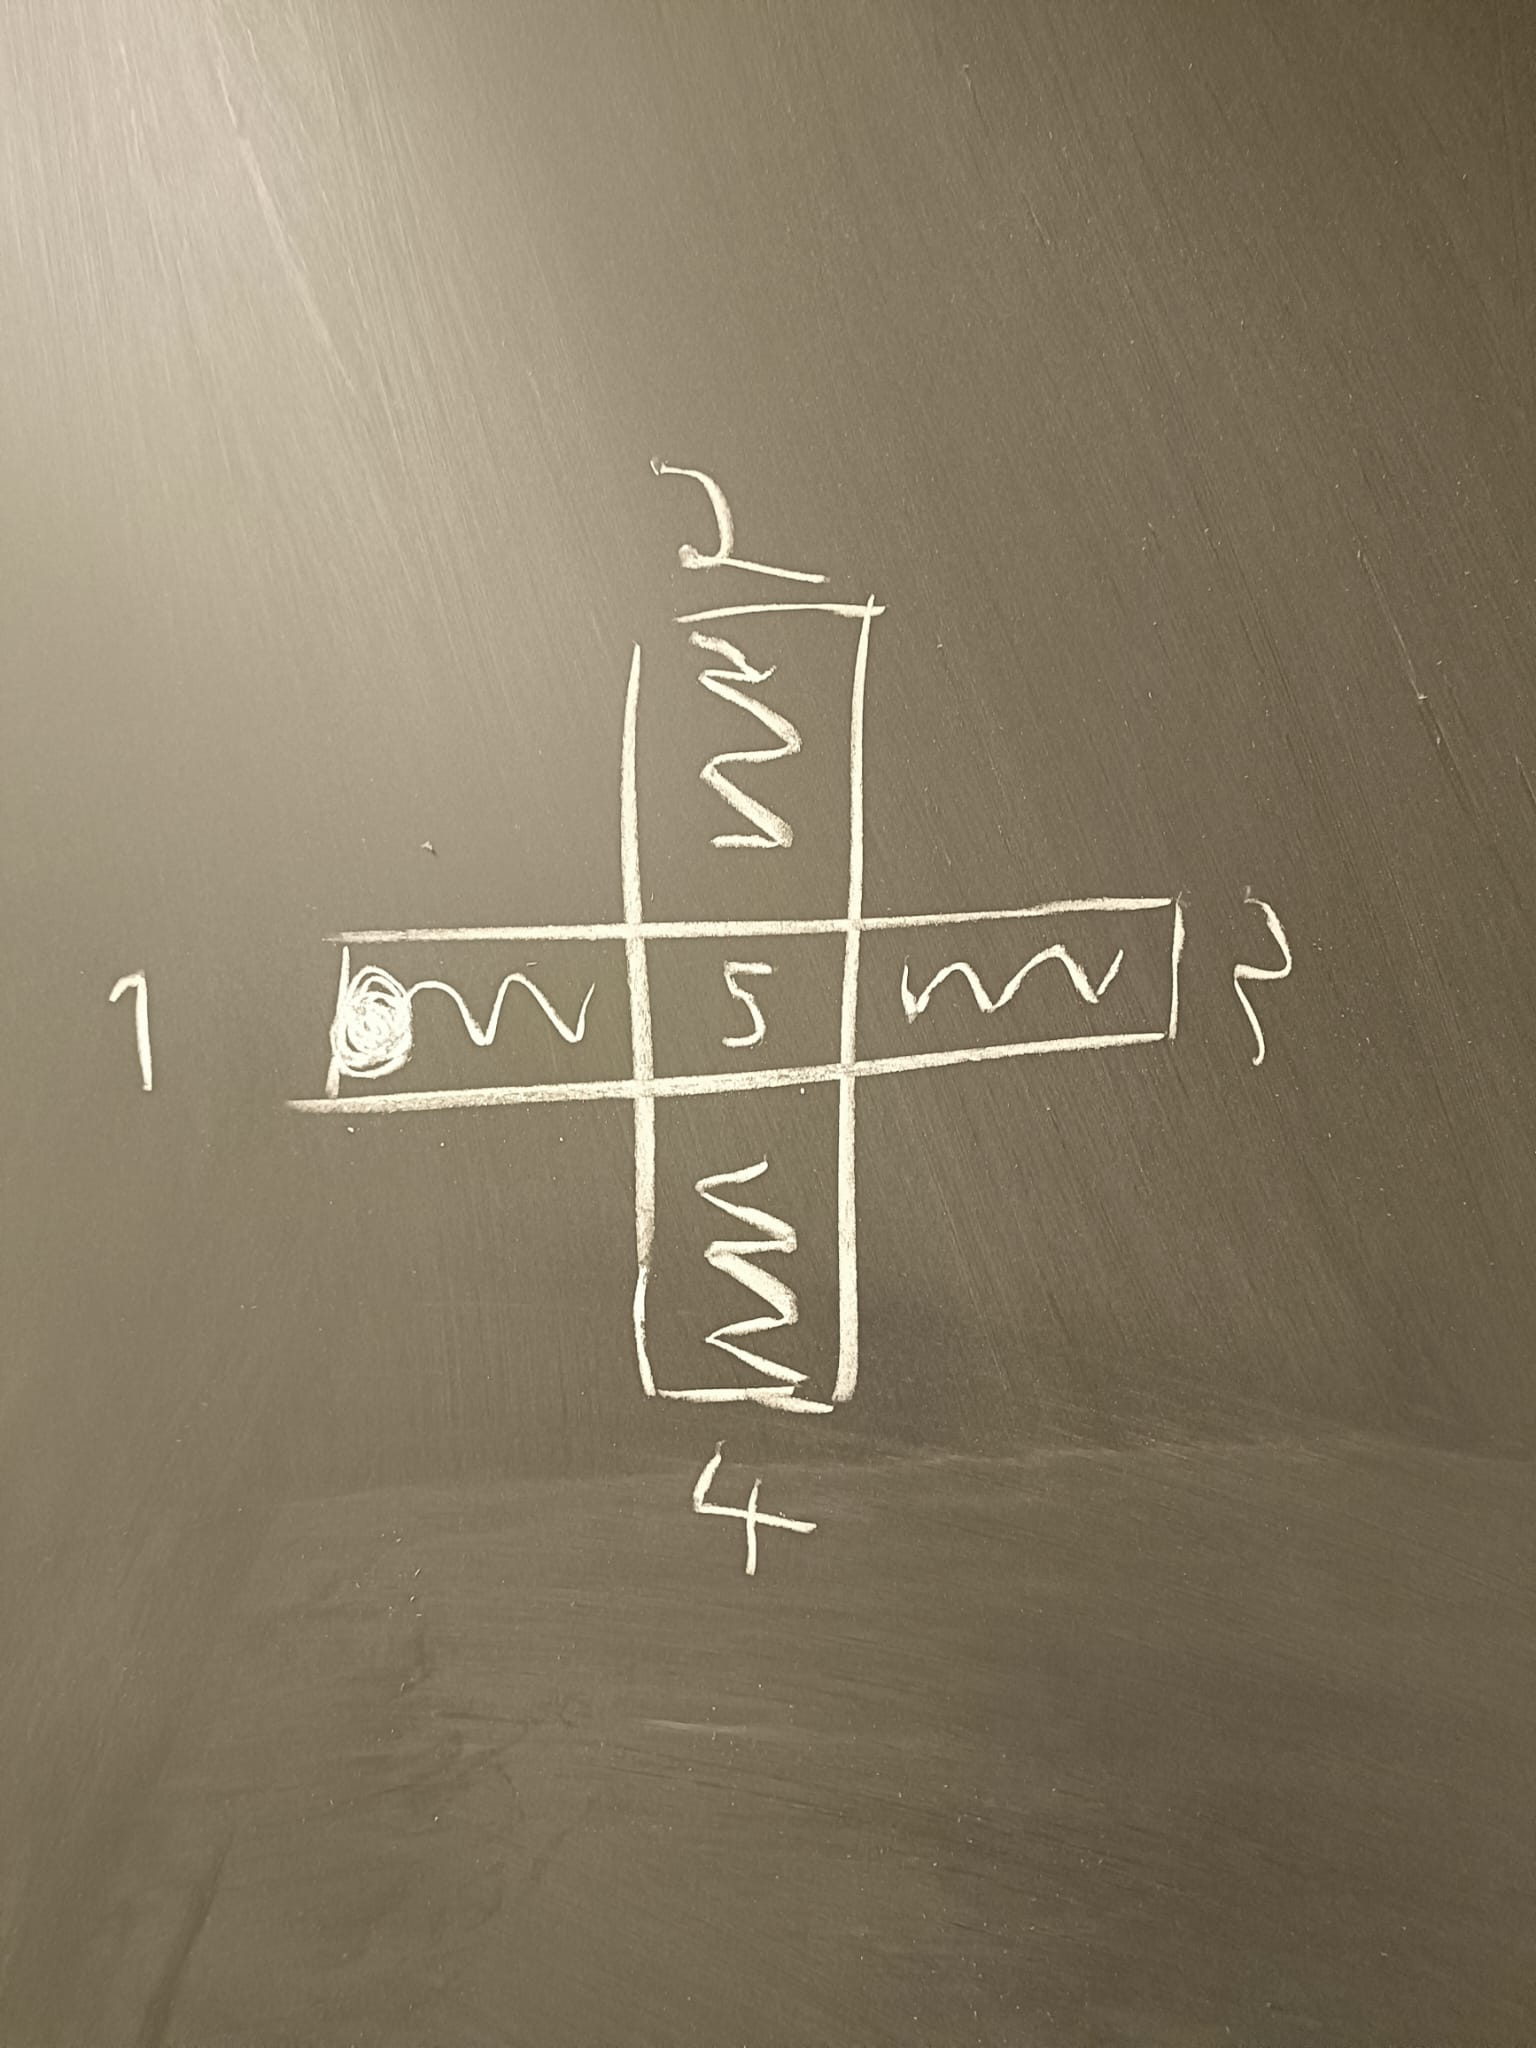
</div>

In [ ]:
# # Build Incidence Matrices and vectors of edges

# EI, EJ, EIEJ_plots, DM, NE, NN = Matrixfuncs.build_incidence(Variabs)     
# Structure = Classes.Net_structure(EI, EJ, EIEJ_plots, DM, NE, NN)

In [ ]:
## Initiate K matrix

# K, K_mat = Matrixfuncs.initiateK(NE, K_max)

In [ ]:
## build network and plot structure

# NET = NETfuncs.buildNetwork(EIEJ_plots)
# pos_lattice = NETfuncs.plotNetStructure(NET, 'Cells')

In [ ]:
## Identify edges at connections of cells and at boundaries for ease of use

# NConncetions = int(NGrid*(NGrid-1)*2)
# EdgesConnections = [int(i) for i in range(NE-NConncetions, NE)]

# NBoundaries = NGrid*4
# left_side = [0 + 4*NGrid*i for i in range(NGrid)]
# bottom_side = [1 + 4*i for i in range(NGrid)]
# right_side = [2 + 4*(NGrid-1) + 4*NGrid*i for i in range(NGrid)]
# top_side = [4*NGrid*(NGrid-1) + 3 + 4*i for i in range(NGrid)]
# EdgesBounaries = np.append(left_side, np.append(bottom_side, np.append(right_side, top_side)))
# # EdgesBounaries = np.array([], int)
# EdgesTotal = np.append(EdgesConnections, EdgesBounaries)

In [ ]:
## Set up constraints for whole loop

# NodeData_full = array([[input_p], [input_p]])  # input p value
# # Nodes_full = array([[6], [35]])  # input p node
# Nodes_full = array([[input_output_pairs[i, 0]] for i in range(len(input_output_pairs))])  # input p node


# GroundNodes_full = array([[input_output_pairs[i, 1]] for i in range(len(input_output_pairs))])  # nodes with zero pressure
# GroundNodes_full_Allostery = array([GroundNodes_full[i][0] for i in range(len(GroundNodes_full))])

# EdgeData_full = array([[0], [0]])  # pressure drop value on edge

# # Edges_full = array([EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[0])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])], 
# #                     EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[1])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])]])

# # Edges_full_Allostery = array([EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[0])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])], 
# #                               EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[1])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])]])

# Edges_full = array([EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[0])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])], 
#                     EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[1])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])]])

# Edges_full_Allostery = array([EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[0])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])], 
#                               EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[1])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])]])

# # Edges_full = array([EdgesConnections, EdgesConnections])
# # output_edges = [np.where(np.append(EI, EJ)==GroundNodes_full[i])[0][0] % len(EI) for i in range(len(GroundNodes_full))]
# output_edges = np.array([np.where(np.append(EI, EJ)==GroundNodes_full[i])[0] % len(EI) 
#                          for i in range(len(GroundNodes_full))])

In [ ]:
## Solve flow with no marbles, i.e. uniform high conductance, for normalization of flow

# u_final_noCond = zeros([2, 2])

# for i in range(2):
#     NodeData = NodeData_full[i] 
#     Nodes = Nodes_full[i] 
#     EdgeData = EdgeData_full[i]
#     Edges = Edges_full[i]
#     GroundNodes = array([GroundNodes_full[0][0], GroundNodes_full[1][0]])
    
#     Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  # As matrix

#     L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#     p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
    
#     # correct for very low velocities
#     u[abs(u)<10**-10] = 0

#     # NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE) 
        
#     # u_final_noCond[i,:] = u[output_edges]
#     u_final_noCond[i,:] = [np.sum(u[output_edges[0]]), np.sum(u[output_edges[1]])]

In [ ]:
# def flow_iterate(iterations, NodeData, Nodes, EdgeData, Edges, GroundNodes, output_edges, DM, K_mat, NN, EI, EJ, flow_scheme, 
#                  sim_type='w marbles', plot='yes'):
    
#     u_final = zeros([2, 2])
#     u_all = np.zeros([NE, iterations])

#     for i in range(iterations):
#         m = i % 2

#         # this is the normal direction of flow

#         NodeData = NodeData_full[m] 
#         Nodes = Nodes_full[m] 
#         EdgeData = EdgeData_full[m]
#         Edges = Edges_full[m]
#         GroundNodes = GroundNodes_full[m]

#         # switch ground and input nodes every 2nd iteration 
#         if i % 4 > 1 and flow_scheme == 'taktak':
#             Nodes = GroundNodes_full[m] 
#             GroundNodes = Nodes_full[m]

#         # As matrix
#         Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  

#         for l in range(3):

#             L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#             p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)

#             # correct for very low velocities
#             u[abs(u)<10**-10] = 0 
            
#             if sim_type == 'w marbles':
#                 K_nxt = Matrixfuncs.ChangeKFromFlow(u, u_thresh, K, K_max, K_min, NGrid)
#                 K_mat = np.eye(NE) * K_nxt
#                 K = copy.copy(K_nxt) 
        
#         if sim_type == 'Allostery test' or sim_type == 'no marbles':
#             u_final[i,:] = [np.sum(u[output_edges[0]]), np.sum(u[output_edges[1]])]
#         else:
#             # p_all[:, i] = p
#             u_all[:, i] = u

#         if plot == 'yes':
#             NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE) 
#     return u_final, u_all, K_mat

In [ ]:
## Loop while changing conductivities

# u_all = np.zeros([NE, iterations])
# for i in range(iterations):
#     m = i % 2
    
#     # this is the normal direction of flow
    
#     NodeData = NodeData_full[m] 
#     Nodes = Nodes_full[m] 
#     EdgeData = EdgeData_full[m]
#     Edges = Edges_full[m]
#     GroundNodes = GroundNodes_full[m]
    
#     # switch ground and input nodes every 2nd iteration 
#     if i % 4 > 1 and flow_scheme == 'taktak':
#         Nodes = GroundNodes_full[m] 
#         GroundNodes = Nodes_full[m]
    
#     # As matrix
#     Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  
    
#     for l in range(3):

#         L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#         p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
        
#         # correct for very low velocities
#         u[abs(u)<10**-10] = 0

#         # NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE)

#         K_nxt = Matrixfuncs.ChangeKFromFlow(u, u_thresh, K, K_max, K_min, NGrid)
#         K_mat = np.eye(NE) * K_nxt
#         K = copy.copy(K_nxt)  
    
#     # p_all[:, i] = p
#     u_all[:, i] = u

In [ ]:
## Allostery Check

# u_final_cond = zeros([2,2])

# for i in range(2):
#     NodeData = NodeData_full[i] 
#     Nodes = Nodes_full[i] 
#     EdgeData = EdgeData_full[i]
#     Edges = Edges_full_Allostery[i]
#     GroundNodes = GroundNodes_full_Allostery
    
#     Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  # As matrix

#     L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#     p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
    
#     # correct for very low velocities
#     u[abs(u)<10**-10] = 0

#     NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE)

#     # u_final_cond[i,:] = u[output_edges]
#     u_final_cond[i,:] = [np.sum(u[output_edges[0]]), np.sum(u[output_edges[1]])]